# Marker Imputation using MAXIM Package

This tutorial introduces the MAXIM package, a tool for marker imputation in multiplex imaging datasets. The tutorial covers the main steps involved in training and evaluating a marker imputation model using MAXIM. It starts with setting up the environment and importing the necessary libraries. The tutorial then demonstrates how to train a model using the `Trainer` class and provides examples of training parameters and data configurations.

Next, the tutorial explores evaluating the trained model on a test set using the `eval` method, which calculates metrics such as SSIM and MAE and visualizes the results. The tutorial also showcases the inference capabilities of the model, generating imputed marker images for a given dataset.

In addition, the tutorial includes an attribution analysis to understand the contribution of input markers to the output marker using the `attributions` method. The tutorial provides visualizations of the attribution percentages for each input marker.

Overall, this tutorial offers a comprehensive overview of the MAXIM package, guiding users through the process of training, evaluating, and analyzing marker imputation models for multiplex imaging datasets.

The first cell sets the CUDA visible devices environment variable to "0" in order to specify that only the first GPU device should be used. It also imports the necessary libraries for the tutorial, including numpy, pandas, and matplotlib. It also imports the Trainer and TrainerCGAN classes from the MAXIM package, which will be used for training and evaluating the marker imputation models.

In [1]:
import os

# Set CUDA_VISIBLE_DEVICES environment variable to control GPU visibility
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from maxim import Trainer
from maxim import TrainerCGAN


## Input parameters initialization

This cell defines the parameters required for marker imputation. It includes the marker panel, input markers, output markers, paths to data CSV files, and the results directory. The Trainer object is then initialized with these parameters. Alternatively, the TrainerCGAN model object can also be used for marker imputation without changing any of the following code. It provides an enhanced version of the Trainer with additional capabilities for conditional generative adversarial network (CGAN) based marker imputation.

In [2]:
marker_panel = ['DAPI', 'FOXP3', 'CD4', 'CD8', 'PDL1', 'KI67', 'CK']
input_markers = ['DAPI', 'FOXP3', 'CD4', 'CD8', 'PDL1', 'CK']
output_markers = ['KI67']
train_valid_test_data_csv_path = '/media/shaban/hd1/Projects_HD1/TIME/Marker_Synthesis/datasets/panel1/train_valid_test_patches_ssd.csv'
inference_data_csv_path = '/media/shaban/hd1/Projects_HD1/TIME/Marker_Synthesis/datasets/panel1/test_images.csv'
results_dir = '/media/shaban/hd1/Projects_HD1/TIME/Marker_Synthesis/results/temp_results/'

# Create an instance of the Trainer class
obj = Trainer(marker_panel=marker_panel, input_markers=input_markers, output_markers=output_markers, results_dir=results_dir, lr=0.002, seed=1)


## Training

In this cell, the train method of the Trainer object is called to train the marker imputation model. The method takes arguments such as the data CSV file path, image size, batch size, and number of workers. The training progress is displayed.

In [3]:
# Train the model using the provided training, validation, and testing data
obj.train(train_valid_test_data_csv_path, percent=100, img_size=256, batch_size=64, num_workers=4, max_epochs=2, minimum_epochs=1, patience=1)

## Evaluation

The eval method of the Trainer object is used in this cell to evaluate the trained model's performance on the test set. It calculates metrics such as SSIM and MAE.

In [4]:
# Evaluate the trained model on the test dataset
obj.eval(train_valid_test_data_csv_path, split_name='test', img_size=256, batch_size=64, num_workers=4)

### Quantitative Results

This cell displays the results in violin plots comparing the MAXIM model with baseline methods.

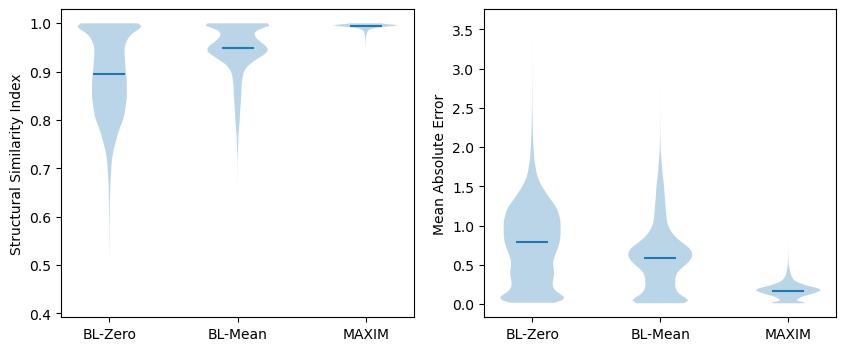

In [5]:
# Read the evaluation results CSV files
bl_zero_res = pd.read_csv(os.path.join(results_dir, 'test_256_256_stats_zero.csv'))
bl_mean_res = pd.read_csv(os.path.join(results_dir, 'test_256_256_stats_mean.csv'))
maxim_res = pd.read_csv(os.path.join(results_dir, 'test_256_256_stats.csv'))

# Create DataFrames for SSIM scores and MAE scores
ssim_scores = pd.DataFrame({'BL-Zero': bl_zero_res['SSIM'], 'BL-Mean': bl_mean_res['SSIM'], 'MAXIM': maxim_res['SSIM']})
mae_scores = pd.DataFrame({'BL-Zero': bl_zero_res['MAE'], 'BL-Mean': bl_mean_res['MAE'], 'MAXIM': maxim_res['MAE']})

# Create a figure with subplots to plot the violin plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot the violin plot for SSIM scores
axs[0].violinplot(ssim_scores, showmedians=True, showextrema=False)
axs[0].set_xticks(range(1, 4))
axs[0].set_xticklabels(['BL-Zero', 'BL-Mean', 'MAXIM'])
axs[0].set_ylabel('Structural Similarity Index')

# Plot the violin plot for MAE scores
axs[1].violinplot(mae_scores, showmedians=True, showextrema=False)
axs[1].set_xticks(range(1, 4))
axs[1].set_xticklabels(['BL-Zero', 'BL-Mean', 'MAXIM'])
axs[1].set_ylabel('Mean Absolute Error')

plt.show()

This cell demonstrates the inference process using the trained model. The eval method is called with the inference data CSV file path, image size, batch size, and number of workers. Imputed marker images are generated for the inference dataset.

In [6]:
# Perform evaluation on the inference dataset
obj.eval(inference_data_csv_path, split_name='inference', img_size=2048, batch_size=1, num_workers=1)

### Visual Results

In this cell, a specific image is selected from the inference dataset, and the real and imputed marker images are displayed side by side using matplotlib.

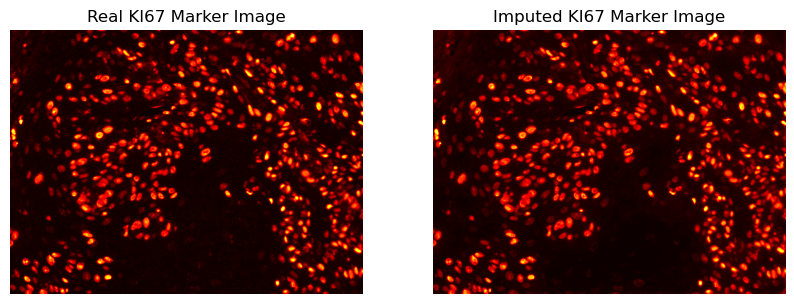

In [7]:
# Read the inference data CSV file
inference_data = pd.read_csv(inference_data_csv_path)

# Select an image from the dataset
image_id = 150  # Replace with the desired image index
image_name = os.path.basename(inference_data['Image_Path'][image_id])

# Load the results of the inference for the selected image
maxim_res = np.load(os.path.join(results_dir, 'inference_2048_2048', image_name))

# Create subplots to display the real and imputed marker images
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Display the real marker image
axs[0].imshow(maxim_res[0], cmap='hot')
axs[0].axis('off')
axs[0].set_title('Real %s Marker Image' % output_markers[0])
axs[0].set_ylabel('Structural Similarity Index')

# Display the imputed marker image
axs[1].imshow(maxim_res[1], cmap='hot')
axs[1].axis('off')
axs[1].set_title('Imputed %s Marker Image' % output_markers[0])

plt.show()


## Model Interpretability Analysis

The attributions method of the Trainer object is utilized in this cell to perform attribution analysis of input markers to the output marker.

In [8]:
# Calculate attributions for the test dataset
obj.attributions(train_valid_test_data_csv_path, split_name='test', img_size=256, batch_size=1, num_workers=1)

The attributions are calculated, and violin plots are generated to visualize the attribution percentages of each input marker to the output marker.

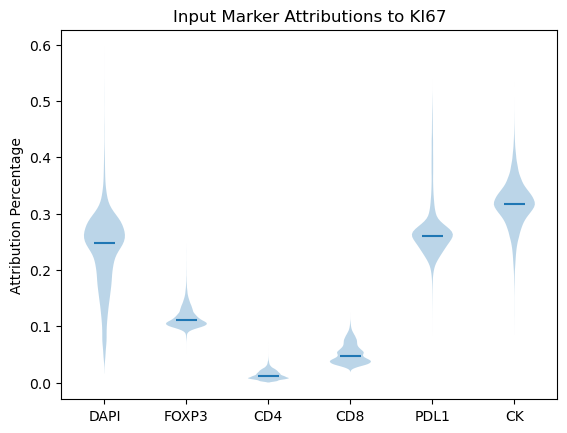

In [9]:
# Read the attribution data from the output file
attributions = pd.read_csv(os.path.join(results_dir, 'attributions_test_256_256_attributions_abs.csv'))

# Convert the attributions to a numpy array
attributions = attributions[input_markers].to_numpy()

# Normalize the attributions
attributions = attributions / np.repeat(np.sum(attributions, 1, keepdims=True), len(input_markers), axis=1)

# Plot violin plots to visualize the attribution percentages
plt.figure()
plt.violinplot(attributions, showmedians=True, showextrema=False)
plt.xticks(range(1, len(input_markers) + 1), input_markers)
plt.ylabel('Attribution Percentage')
plt.title('Input Marker Attributions to %s' % output_markers[0])

plt.show()